## Description

Задача бинарной классификации сообщений из Телеграма на спам. В качестве датасета размеченные данные из Телеграма за один месяц.
Проект описывает этапы препроцессинга, EDA, векторного преобразования слов с последующей классификацией с помощью RandomForest, XGBoost и Catboost. Помимо этого настроим и обучим трансформер BERT с помощью PytorchLighting

In [1]:
# !pip install -r requirements.txt

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from lightning_transformers.task.nlp.text_classification import (
    TextClassificationDataModule,
    TextClassificationTransformer,
)
from transformers import AutoTokenizer
from glob import glob
import pytorch_lightning as pl
from sklearn import metrics
import re

In [3]:
train_path=os.path.join('dataset','train.json')
test_path=os.path.join('dataset','test.json')
eval_path=os.path.join('dataset','eval.json')
df_path=os.path.join('dataset','df.json')
report_path = 'result.json'
origin_bert_name = 'bert-base-multilingual-uncased'
modified_bert_name = 'spam-bert-multilingual'
w2v_model_name = 'word2v.model'

In [4]:
def show_metrics (y, preds):
    fpr, tpr, thresholds = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot();
    print(metrics.classification_report(y, preds))
    cm=metrics.confusion_matrix(y,preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();

## Preproccess files
Импорт сообщений состоит из бота выдающего сообщения о спаме, а также сотрудника, который посмечает сообщения (SPAM/NO)

In [4]:
employer_id = 'user32512143'
contractor_bot_id = 'user913646289'

Получение и парсинг данных

In [5]:
with open(report_path, 'r', encoding="utf8") as json_file:
    data = json.load(json_file)

data_messages=pd.DataFrame(data['messages'])
data_messages.head(10)

,id,type,date,date_unixtime,from,from_id,forwarded_from,text,text_entities,reply_to_message_id,...,mime_type,duration_seconds,via_bot,poll,performer,title,contact_information,contact_vcard,edited,edited_unixtime
0,9000000,message,2022-08-07T12:45:51,1659858351,Spam Contractor Bot,user913646289,Vân Anh,"[{'type': 'italic', 'text': '🌕 0%'}, \nNạp 1tr...","[{'type': 'italic', 'text': '🌕 0%'}, {'type': ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9000001,message,2022-08-07T12:45:51,1659858351,Spam Contractor Bot,user913646289,NaN,"[{'type': 'hashtag', 'text': '#r785281986'}, ,...","[{'type': 'hashtag', 'text': '#r785281986'}, {...",9000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9000002,message,2022-08-07T12:45:55,1659858355,Kirill Fomenko,user32512143,NaN,😌 NO,"[{'type': 'plain', 'text': '😌 NO'}]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9000003,message,2022-08-07T12:45:55,1659858355,Spam Contractor Bot,user913646289,NaN,"[Report , {'type': 'hashtag', 'text': '#r78528...","[{'type': 'plain', 'text': 'Report '}, {'type'...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9000004,message,2022-08-07T12:45:55,1659858355,Spam Contractor Bot,user913646289,Артём Грузнов,"[{'type': 'italic', 'text': '🌚 100%'}, \n❗ВНИМ...","[{'type': 'italic', 'text': '🌚 100%'}, {'type'...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9000005,message,2022-08-07T12:45:55,1659858355,Spam Contractor Bot,user913646289,NaN,"[{'type': 'hashtag', 'text': '#r782066297'}, ,...","[{'type': 'hashtag', 'text': '#r782066297'}, {...",9000004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9000006,message,2022-08-07T12:45:56,1659858356,Kirill Fomenko,user32512143,NaN,😡 SPAM,"[{'type': 'plain', 'text': '😡 SPAM'}]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9000007,message,2022-08-07T12:45:56,1659858356,Spam Contractor Bot,user913646289,NaN,"[Report , {'type': 'hashtag', 'text': '#r78206...","[{'type': 'plain', 'text': 'Report '}, {'type'...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9000008,message,2022-08-07T12:45:56,1659858356,Spam Contractor Bot,user913646289,Nguyễn Thị Bích Liên,"[{'type': 'italic', 'text': '🌕 0%'}, \n, {'typ...","[{'type': 'italic', 'text': '🌕 0%'}, {'type': ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9000009,message,2022-08-07T12:45:56,1659858356,Spam Contractor Bot,user913646289,NaN,"[{'type': 'hashtag', 'text': '#r786017572'}, ,...","[{'type': 'hashtag', 'text': '#r786017572'}, {...",9000008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пример сообщений

In [6]:
data_messages['text'][:10].values

array([list([{'type': 'italic', 'text': '🌕 0%'}, '\nNạp 1tr km 500k 2 vòng cược ai qt ib em ( đạt chỉ tiêu được bank thêm 200k )']),
       list([{'type': 'hashtag', 'text': '#r785281986'}, ', 😱11\n', {'type': 'bold', 'text': 'Source:'}, ' Trường Giang - DOMINO - ( Baccarat&#39;… ', {'type': 'mention', 'text': '@truonggiang7979'}, '\n', {'type': 'bold', 'text': 'Sender:'}, ' 🇻🇳 VNM, Vân Anh , ', {'type': 'mention', 'text': '@anhxinh68'}, '\n07.08.22, 07:43  🌕 0%\n', {'type': 'bot_command', 'text': '/pattern785281986'}, ' · ', {'type': 'bot_command', 'text': '/abuse785281986'}, ' · ', {'type': 'bot_command', 'text': '/eng785281986'}, '']),
       '😌 NO',
       list(['Report ', {'type': 'hashtag', 'text': '#r785281986'}, ' marked as not spam 😌\nSend ', {'type': 'bot_command', 'text': '/undo785281986'}, ' to revert your decision.']),
       list([{'type': 'italic', 'text': '🌚 100%'}, '\n❗ВНИМАНИЯ❗\n\n Успей купить по выгодной цене \n⤵️Личные кабинеты банков 🏦\n\n✅Moneybase\n✅Revolut, \n✅

In [7]:
data_messages.shape

(1057393, 27)

Заводим массив сообщений, каждый раз когда когда пользователь даёт оценку, сохраняем сообщение, когда "говорит" бот запоминаем текст сообщения и его автора

In [8]:
messages = []
msg = {}
text=''

for message in data['messages']:
    if message.__contains__('from_id'):
        if (message['from_id']==employer_id):
            marked = False
            if (message['text']=='😌 NO'):
                msg['spam']=0
                marked = True

            if (message['text']=='😡 SPAM'):
                msg['spam']=1
                marked = True

            if (marked):
                msg['id']=message['id']
                msg['text']=text.replace('\n',' ')
                text=''
                msg={}
                messages.append(msg)

                
        if (message['from_id']==contractor_bot_id):
            if (message.__contains__('forwarded_from')):
                if (message['forwarded_from'] is not None):
                    msg['author'] = message['forwarded_from']
                    
                for each in message['text'][1:]:
                    if (type(each)==str):
                        text+=' '+each
                    elif each.__contains__('type'):
                        if each['type']=='link':
                            msg['link']=1
                        text+=' '+each['text']
                
                

            if (message.__contains__('reply_to_message_id')):
                if message['text'][0]=='🔴 ':
                    msg['source']=message['text'][4]
                else:
                    msg['source']=message['text'][3]
        
df=pd.DataFrame(messages).fillna(0)        

### EDA

In [9]:
df.describe(include='all')

,author,source,spam,id,text,link
count,257856.0,257856,257856.000000,2.578560e+05,257856,257856.000000
unique,141830.0,121055,NaN,NaN,179024,NaN
top,0.0,,NaN,NaN,,NaN
freq,55633.0,6114,NaN,NaN,17029,NaN
mean,NaN,NaN,0.521702,9.466446e+06,NaN,0.204029
std,NaN,NaN,0.499530,3.129677e+05,NaN,0.402991
min,NaN,NaN,0.000000,0.000000e+00,NaN,0.000000
25%,NaN,NaN,0.000000,9.195241e+06,NaN,0.000000
50%,NaN,NaN,1.000000,9.464955e+06,NaN,0.000000
75%,NaN,NaN,1.000000,9.738300e+06,NaN,0.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257856 entries, 0 to 257855
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   author  257856 non-null  object 
 1   source  257856 non-null  object 
 2   spam    257856 non-null  float64
 3   id      257856 non-null  float64
 4   text    257856 non-null  object 
 5   link    257856 non-null  float64
dtypes: float64(3), object(3)
memory usage: 11.8+ MB


In [11]:
df[['author','source','text']]=df[['author','source','text']].astype(dtype='str',)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257856 entries, 0 to 257855
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   author  257856 non-null  object 
 1   source  257856 non-null  object 
 2   spam    257856 non-null  float64
 3   id      257856 non-null  float64
 4   text    257856 non-null  object 
 5   link    257856 non-null  float64
dtypes: float64(3), object(3)
memory usage: 11.8+ MB


Почистим данные по длине строки

<AxesSubplot:>

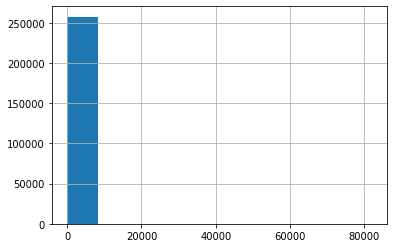

In [13]:
df['len_text']=df['text'].astype('str').apply(lambda x: len(x))
df['len_text'].hist()

<AxesSubplot:>

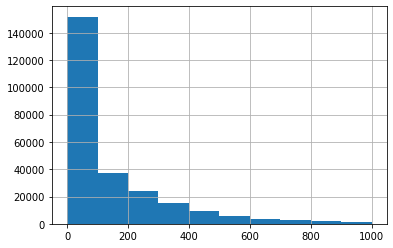

In [17]:
df[df['len_text']<1000]['len_text'].hist()

<AxesSubplot:title={'center':'len_text'}, xlabel='spam'>

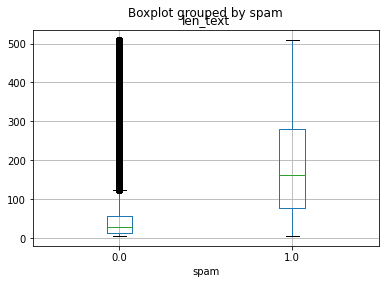

In [20]:
IQR = df['len_text'].quantile(0.75) - df['len_text'].quantile(0.25)
up_bound = df['len_text'].quantile(0.75) + (IQR * 1.5)
df = df[(df['len_text']>5) & (df['len_text']<up_bound)]
df.boxplot(column='len_text', by='spam')

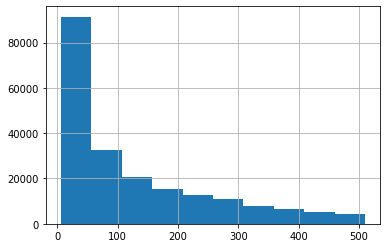

In [23]:
df['len_text'].hist();

Объединяем автора сообщения с самим сообщением (Бывает случаи когда "тело" спама находится в имени автора)

In [24]:
df.text = df.author.astype(str).str.cat(df.text)

Делим выборку на тренировочную, тестовую и проверочную

In [25]:
df_save = df[['spam','text']]
df_save.columns = ['label','text']
train_test, eval = train_test_split(df_save, train_size=0.9)
train, test = train_test_split(train_test, train_size=0.9)

In [26]:
test.head()

,label,text
236169,0.0,"FILL Привет, кто со мной мяукать??"
200933,0.0,Pr0v0 C//p Pr0v0 🔞🔥
205894,1.0,Cskhgiftcode 🎁 CODE 300K 𝐕𝐔𝐀𝟔𝟗CLUB ✅ FULL COD...
115619,1.0,0 🚨PLEASE PAY ATTENTION🚨 Telegram is now home...
120610,0.0,𝑷𝒐'𝒙𝒙𝒐𝒚 𝑹𝒆𝒋𝒊𝒎.......𝑶𝒏 Mengga qara hurmatli l...


Сохранение разметки

In [27]:
train.to_json(train_path,orient='records', force_ascii=False)
test.to_json(test_path,orient='records', force_ascii=False)
eval.to_json(eval_path,orient='records', force_ascii=False)
df_save.to_json(df_path,orient='records', force_ascii=False)

## Word-2-Vec + gensim

In [5]:
from gensim.models import Word2Vec
from pymystem3 import Mystem
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer #, KNNImputer
from sklearn.compose import make_column_selector
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
import catboost
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
display(HTML("<style>.container { width:80% !important; }</style>"))

In [6]:
df_save=pd.read_json(df_path,orient='records')
train=pd.read_json(train_path,orient='records')
test=pd.read_json(test_path,orient='records')

In [7]:
m = Mystem()
regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

words_only('Проверка 1 лемматизации и 1 проверки на слова :))')

'Проверка лемматизации и проверки на слова :))'

In [8]:
%time df_save.text = df_save.text.apply(words_only)
%time df_save.text = df_save.text.apply(lemmatize)

CPU times: user 1.39 s, sys: 205 ms, total: 1.59 s
Wall time: 9.4 s
CPU times: user 19.4 s, sys: 3.09 s, total: 22.5 s
Wall time: 6min 8s


In [9]:
texts = [df_save.text.iloc[i].split() for i in range(len(df_save))]

In [10]:
%%time
model = Word2Vec(texts, window=5, min_count=5, workers=4)
model.save("word2v.model")

CPU times: user 47.4 s, sys: 5.08 s, total: 52.5 s
Wall time: 27.7 s


In [11]:
model = Word2Vec.load(w2v_model_name) 

In [10]:
model.wv.most_similar("лс")

[('личка', 0.9578715562820435),
 ('ЛС', 0.9501171708106995),
 ('Лс', 0.8801920413970947),
 ('директ', 0.8724393844604492),
 ('лс)', 0.8688517212867737),
 ('л/с', 0.8661670088768005),
 ('ЛС)', 0.863395631313324),
 ('личка!', 0.8515932559967041),
 ('ЛС!', 0.8509644865989685),
 ('ТГ', 0.84438157081604)]

In [11]:
model.wv.most_similar("меф")

[('гаш', 0.9680689573287964),
 ('ск', 0.9653255939483643),
 ('шишка', 0.9432579874992371),
 ('мефедрон', 0.9315119981765747),
 ('кристалл', 0.928811252117157),
 ('гашиш', 0.9156591892242432),
 ('крис', 0.9125720858573914),
 ('метадон', 0.9113448262214661),
 ('гр', 0.896694004535675),
 ('соль', 0.8857972025871277)]

In [12]:
%time train.text = train.text.apply(words_only).apply(lemmatize)
%time test.text = test.text.apply(words_only).apply(lemmatize)

CPU times: user 11 s, sys: 1.32 s, total: 12.3 s
Wall time: 1min 2s
CPU times: user 1.26 s, sys: 77.6 ms, total: 1.34 s
Wall time: 6.18 s


In [13]:
X_train = train.text.tolist()
y_train = train.label.tolist()
X_test = test.text.tolist()
y_test = test.label.tolist()

print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 167803
total test examples 18645


In [14]:
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      8696
           1       0.89      0.88      0.89      9949

    accuracy                           0.88     18645
   macro avg       0.88      0.88      0.88     18645
weighted avg       0.88      0.88      0.88     18645



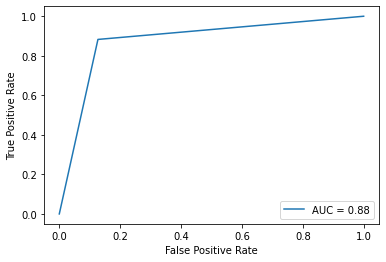

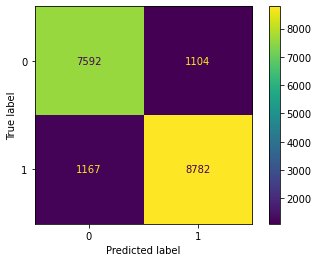

In [30]:
from xgboost import XGBClassifier
rfc_w2v = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("classifier", XGBClassifier())
])

rfc_w2v.fit(X_train,y_train)
preds = rfc_w2v.predict(X_test)
show_metrics(y_test, preds)

In [22]:
rfc_w2v = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("classifier", RandomForestClassifier(n_estimators=100))])

rfc_w2v.fit(X_train,y_train)
preds = rfc_w2v.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      8696
           1       0.91      0.86      0.88      9949

    accuracy                           0.88     18645
   macro avg       0.88      0.88      0.88     18645
weighted avg       0.88      0.88      0.88     18645



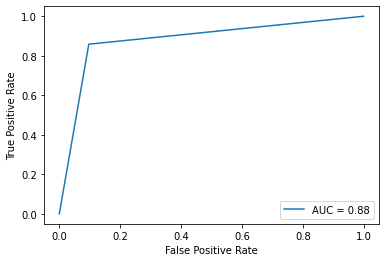

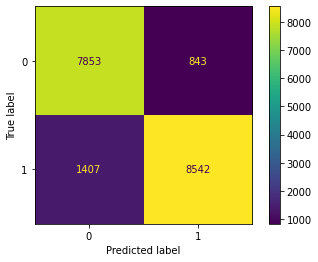

In [16]:
show_metrics(y_test, preds)

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score, average='macro')

param_grid = {
    'classifier__bootstrap': [False],
    'classifier__max_depth': [70],
    'classifier__max_features': ['auto'],
    'classifier__min_samples_leaf': [1],
    'classifier__min_samples_split': [3, 5, 7],
    'classifier__n_estimators': [500, 600, 800],

}

search = GridSearchCV(rfc_w2v, param_grid, 
                      verbose=True, 
                      n_jobs=-1, cv=3, scoring=f1)

search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [ ]:
search.best_params_

{'classifier__bootstrap': False,
 'classifier__max_depth': 70,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 600}

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      8696
           1       0.91      0.86      0.88      9949

    accuracy                           0.88     18645
   macro avg       0.88      0.88      0.88     18645
weighted avg       0.88      0.88      0.88     18645



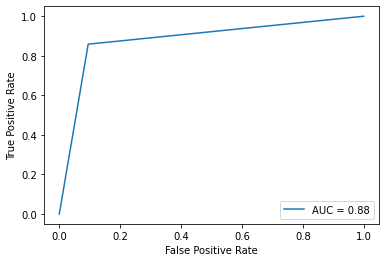

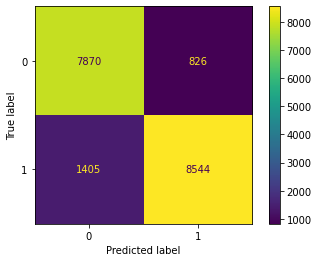

In [ ]:
preds = search.predict(X_test)
show_metrics(y_test, preds)

In [17]:
preprocessor = Pipeline(steps=[
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    # ("feature_selector", SelectKBest(score_func=f_classif, k="all"))
    ])


estimators = [
    ("SVM", make_pipeline(preprocessor, LinearSVC())),
    ("Random_Forest", make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1))),
    ("xgboost", make_pipeline(preprocessor, xgboost.XGBClassifier(n_jobs=-1))),
    # ("catboost", make_pipeline(preprocessor, catboost.CatBoostClassifier(verbose=False)))
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, verbose=True),
    n_jobs=-1,
    verbose=True,
)

In [18]:
stacking_classifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('word2vec '
                                                                  'vectorizer',
                                                                  <__main__.TfidfEmbeddingVectorizer object at 0x7feff7a4f760>)])),
                                                ('linearsvc', LinearSVC())])),
                               ('Random_Forest',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('word2vec '
                                                                  'vectorizer',
                                                                  <__main__.TfidfEmbeddingVectorizer object at 0x7feff7a4f760>)])),
                                                ('rand...
                                                               max_bin=No

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      8696
           1       0.90      0.88      0.89      9949

    accuracy                           0.89     18645
   macro avg       0.88      0.89      0.89     18645
weighted avg       0.89      0.89      0.89     18645



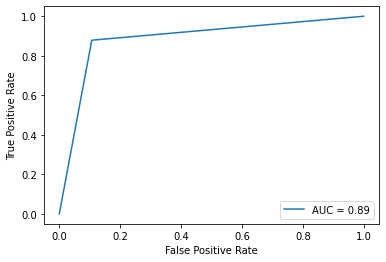

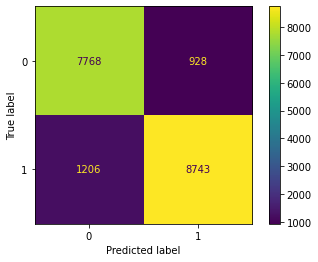

In [19]:
preds = stacking_classifier.predict(X_test)
show_metrics(y_test, preds)

In [21]:
import pickle
with open('stacking_pipeline.pkl','wb') as f:
    pickle.dump(stacking_classifier, f)

AttributeError: Can't pickle local object 'TfidfEmbeddingVectorizer.fit.<locals>.<lambda>'

## BERT PyTorch Lightning
Обучим BERT с помощью PyTorch Lightning

In [16]:
tok_kwargs = dict(padding="max_length", truncation=True, max_length=128)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=origin_bert_name)
dm = TextClassificationDataModule(
    batch_size=32,
    train_file=train_path,
    validation_file=test_path,
    tokenizer=tokenizer,
    **tok_kwargs
)

In [17]:
model = TextClassificationTransformer(
    pretrained_model_name_or_path=origin_bert_name,
    num_labels=dm.num_classes
)

Using custom data configuration default-4b8fbdee0bdfbfcf
Found cached dataset json (/home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/184 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/184 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/19 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/21 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/21 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [19]:
trainer = pl.Trainer(accelerator="auto", devices="auto", max_epochs=4)
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using custom data configuration default-4b8fbdee0bdfbfcf
Found cached dataset json (/home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-33192eb87ef5831b.arrow


Stringifying the column:   0%|          | 0/184 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/184 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/19 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-8b29ed82ee5ae44b.arrow
Loading cached processed dataset at /home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-6a95471788c199b0.arrow
Loading cached processed dataset at /home/Kirill.Fomenko/.cache/huggingface/datasets/json/default-4b8fbdee0bdfbfcf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0e950e99e51366f7.arrow
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name   | Type                          | Params
---------------------------------------------------------
0 | model  | BertForSequenceClassification | 167 M 
1 | prec   | Precision                     | 0     
2 | recall | Recall            

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model.hf_predict("Всем привет. Как дела?")

[{'label': 'LABEL_0', 'score': 0.9818226099014282}]

In [ ]:
model.hf_predict("Trading starts TOMORROW!💰 Let’s take a look at projected earnings for these trading accounts! ")

[{'label': 'LABEL_1', 'score': 0.7927154302597046}]

In [18]:
model.save_hf_checkpoint(modified_bert_name)
tokenizer.save_vocabulary(modified_bert_name)

## Results

### Bert

In [31]:
model=model.cuda()

In [62]:
df_eval=pd.read_json(eval_path,orient='records')
X = df_eval.text.values
y = df_eval.label.values

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path='./spam-bert-multilingual')
model = TextClassificationTransformer(
    pretrained_model_name_or_path="./spam-bert-multilingual",
    tokenizer=tokenizer
)
model.eval()
model.hf_predict('Are you spam?')

predicts = model.hf_predict(X.tolist())
preds=[int(predict['label'][-1]) for predict in predicts]

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      9922
           1       0.93      0.94      0.94     12730

    accuracy                           0.93     22652
   macro avg       0.93      0.93      0.93     22652
weighted avg       0.93      0.93      0.93     22652



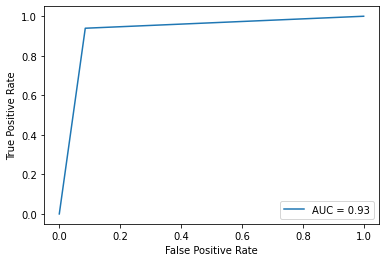

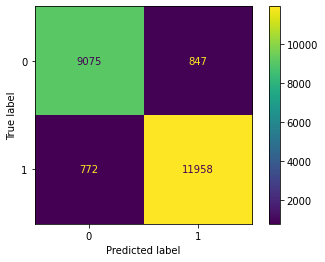

In [ ]:
show_metrics(y, preds)